In [337]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
from praw.exceptions import ClientException
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors

from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance, plot_partial_dependence

from imblearn.ensemble import BalancedRandomForestClassifier

import pickle

from scipy import interp

import string
from pprint import pprint

from multiprocessing import Pool

In [338]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [339]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [340]:
client = MongoClient('localhost', 27017)
db = client['cap2']

In [341]:
# get all comments into a list called 'docs', then make dataframe
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [342]:
comms = pd.DataFrame(docs)

In [ ]:
# TODO add submission ids to the set of ids from trolls, probably append 't1_' to comments
# for ease of use

## assign labels, 'troll?', and 'child_of_troll?', and 'parent_of_troll?'

In [343]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
np.sum(comms['troll?'])

6704

In [344]:
# is this comment in reply to a troll?
# TODO: expand the notion of a reply to troll by including top-level comments directly responding to posts by trolls
comms['child_of_troll?'] = [int(mybool) for mybool in [
                    pid.split('_')[1] in troll_comment_ids_set for pid in comms['parent_id']
                    ]]
np.sum(comms['child_of_troll?'])

2985

In [345]:
# did a troll reply to this?
troll_parent_ids_set = set(
                            [p.split('_')[1] for p in comms[~comms['author'].isna()]['parent_id']]
                        )
comms['parent_of_troll?'] = [int(myid in troll_parent_ids_set) for myid in comms['id']]

np.sum(comms['parent_of_troll?'])

1824

## engineer feature: norm_depth
#### currently there are 1430 comments with neither a 'nest_level' nor a 'depth'

In [346]:
# actually, even easier, use fillna(0) later
comms['norm_depth'] = np.where(~comms['depth'].isna(), comms['depth'], comms['nest_level']-1)

In [ ]:
parent_ids = np.unique(comms[~comms['author'].isna()]['parent_id'])
len(parent_ids)

In [ ]:
t1_parent_ids=[]
for p in parent_ids:
    if p[:2]=='t1':
        t1_parent_ids.append(p.split('_')[1])
set_parent_ids = set(t1_parent_ids)
set_parent_of_troll = set(comms[comms['parent_of_troll?']==1]['id'])
# how does a differ from 
len(set_parent_ids), len(set_parent_of_troll)

In [142]:
def printall(pd_obj):
    '''
    print every row and column in a pandas object
    '''
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd_obj)

In [347]:
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
author        : 141998
first_and_last:    964
comment       : 234008


## NLP

In [348]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)
stopwords_ = orig_stopwords_

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [349]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [13]:
# this takes a few minutes, and uses about 100 MB of RAM
# corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

# or use multiprocessing
agents = 30 # number of cores
chunksize = 3500
p = Pool(agents)
corpus = p.map(nlp_pre_proc_doc, comms['body'], chunksize=chunksize)
p.close()
p.join()

# try multiprocessing!
# agents = 30 # number of cores
# chunksize = 3500
# p = Pool(agents)
# corpus = p.map(nlp_pre_proc_doc, comms['body'], chunksize=chunksize)
# p.close()
# p.join()

## Train classifier(s)

In [351]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### train test split -- target is `child_of_troll?`

In [391]:
# going out of order, ugh
# X_train_corp, X_test_corp, y_train, y_test = train_test_split(
_, _, y_train, y_test = train_test_split(
        corpus, comms['child_of_troll?'], test_size=0.2, random_state=30, shuffle=True)

In [353]:
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [354]:
t0 = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 2.994s.


In [355]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [356]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [372]:
# add extra features to the tfidf matrix
# TODO make this a function
# comms_meta = ['controversiality', 'score', 'norm_depth'] # controversiality hurts the model b/c null enriched in troll
comms_meta = ['score', 'norm_depth']
# comms_meta = []
Xcsd_train = np.hstack([X_train, comms[comms_meta].fillna(0).values[y_train.index]])
Xcsd_test = np.hstack([X_test, comms[comms_meta].fillna(0).values[y_test.index]])


In [373]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [392]:
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsd_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

## model inspection

In [365]:
def accuracy(y_true, y_predict):
    (TP, FP), (FN, TN) = standard_confusion_matrix(y_true, y_predict)
    num_correct = TP + TN
    num_incorrect = FP + FN
    return num_correct / (num_correct + num_incorrect)

def standard_confusion_matrix(y_true, y_predict):
    """
    y_true = [1, 1, 1, 1, 1, 0, 0]

    y_predict = [1, 1, 1, 1, 0, 0, 0]

    In [1]: standard_confusion_matrix(y_true, y_predict)
    >> array([[4., 1.],
    >>       [0., 2.]])
    """
    cm = np.zeros((2,2))
    X = np.array([y_true, y_predict])
    values, counts = np.unique(X, axis=1, return_counts=True)
    for i, v in enumerate(values.T):
        cm[tuple([1, 1] - v)] = counts[i]
    return cm.T.astype(int)

# from the lecture
# Just handy function to make our confusion matrix pretty 
def plot_confusion_matrix(cm, # confusion matrix
                          classes_x, # test to describe what the output of the classes may be (commonly 1 or 0)
                          classes_y,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_x))
    plt.xticks(tick_marks, classes_x, rotation=45)
    plt.yticks(tick_marks, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [366]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

In [27]:
# include the model for comparisons
clfs['cot_brf'] = brf

In [375]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsd_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsd_test)
np.sum(y_predict)


 R^2 score: 0.8300713644716038

 Out of bag score: 0.6187614926987561


8097

In [376]:
(TP, FP), (FN, TN) = standard_confusion_matrix(y_test, y_predict)
accuracy = (TP + TN) / (TP + FP + FN + TN)
print("\n accuracy:", accuracy)
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 accuracy: 0.8300713644716038

 precision: 0.09015684821538841
    recall: 0.5547112462006079


<ipython-input-26-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


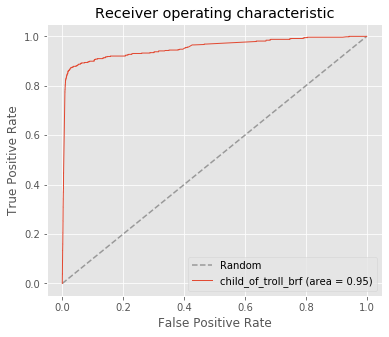

In [30]:
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsd_test, y_test, clfs['cot_brf'], 'child_of_troll_brf')

### pickle this model

In [ ]:
filename = 'data/saved_models/child_of_troll_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(clfs['cot_brf'], fp)

### test de-pickle

In [ ]:
with open('data/saved_models/child_of_troll_brf.pkl', 'rb') as fp:
    new_brf = pickle.load(fp)

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsd_test, y_test, new_brf, 'child_of_troll_brf')

## now train model for `troll?`
first, without using any info from child_of_troll classification

In [409]:
# X doesn't change, but y does

_, _, y_train, y_test = train_test_split(
        corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

In [361]:
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsd_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [362]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsd_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsd_test)
np.sum(y_predict)


 R^2 score: 0.7221699927353532

 Out of bag score: 0.6381449432125473


13131

In [363]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))
standard_confusion_matrix(y_test, y_predict)


 precision: 0.05498438808925444
    recall: 0.5486322188449848


array([[  722, 12409],
       [  594, 33077]])

<ipython-input-366-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


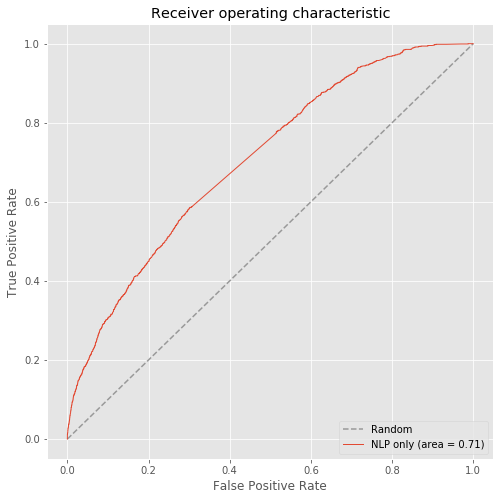

In [425]:
# clfs['NLP only'] = brf
# clfs['NLP + meta'] = brf
clfs['NLP+meta+RTT'] = brf
# X_test = Xcsd_test
# X_test2 = Xcsd_test
X_test3 = Xcsdt_test
# using the depth added about 5% to auc
fig, ax = plt.subplots(1, figsize=(8, 8))
plot_roc_nofit(ax, X_test, y_test, clfs['NLP only'], 'NLP only')
#plot_roc_nofit(ax, X_test2, y_test, clfs['NLP + meta'], 'NLP+meta')
#plot_roc_nofit(ax, X_test3, y_test, clfs['NLP+meta+RTT'], 'NLP+meta+RTT')
plt.savefig('img/roc_one_model.png')

### pickle this model

In [ ]:
filename = 'troll_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(brf, fp)

### what about engineering the user age at time of comment. That could be interesting

In [ ]:
'created_utc' in comms.columns, 'author_created_utc' in comms.columns, 'user_age' in comms.columns

In [13]:
comms['user_age'] = comms['created_utc'] - comms['author_created_utc']

In [ ]:
# just to be certain, I re-split/tfidf/values and y_train, using the same random state to reset the training and test data
# e.g.
#     X_train_corp, X_test_corp, y_train, y_test = train_test_split(
#             corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

#     n_features = 5000

#     tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                        max_features=n_features,
#                                        stop_words='english')

#     t0 = time.time()
#     X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
#     print("done in %0.3fs." % (time.time() - t0))

#     X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

#     X_train = X_train_tfidf.toarray()
#     X_test = X_test_tfidf.toarray()
# update the feature matrix
cols_to_add = ['controversiality', 'score', 'norm_depth', 'user_age']
Xcsdu_train = np.hstack([X_train, comms[cols_to_add].fillna(0).values[y_train.index]])
Xcsdu_test = np.hstack([X_test, comms[cols_to_add].fillna(0).values[y_test.index]])

In [ ]:
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsdu_train, y_train)

In [ ]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsdu_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsdu_test)
np.sum(y_predict)

In [ ]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsdu_test, y_test, brf, 'troll_brf')

### Yay! awww, that's leakage...but it gives me future directions for the project.

### next engineer the `child_suggests_troll?` and `num_replies` features
First, just make this `1` if any of its replies have `child_of_troll? == 1`

In [ ]:
# confirmed that every comment has a value for parent_id
comms.info()

In [380]:
count_grouped_parent_id_comms = comms.groupby('parent_id')['body'].count()

In [381]:
parent_reply_counts = dict(zip(count_grouped_parent_id_comms.index, count_grouped_parent_id_comms.tolist()))

In [382]:
# numpy array with top_level code (t1 or t3), parent_id, and count
np_parent_reply_counts = np.array([k.split('_') + [v] for k, v in parent_reply_counts.items()])

In [383]:
# one-hot encode 'top_level?''
top_level = np.where(np_parent_reply_counts[:,0]=='t3', np.ones(len(np_parent_reply_counts)), np.zeros(len(np_parent_reply_counts)))

In [384]:
# TODO: make the following few cells a pre-processing function
# now treat the entire corpus as new data
X_corp = corpus

In [385]:
# TODO: encapsulate this into a pre-processing function ...
t0 = time.time()
X_tfidf = tfidf_vectorizer.transform(X_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 3.440s.


In [386]:
# TODO: encapsulate this into a pre-processing function ...
X = X_tfidf.toarray()

In [387]:
# TODO: encapsulate this into a pre-processing function ...
Xcsd = np.hstack([X, comms[comms_meta].fillna(0).values])

### make predictions for `child_of_troll?`

In [388]:
# get child_of_troll? model predictions for entire dataset
with open('data/saved_models/child_of_troll_brf.pkl', 'rb') as fp:
    brf = pickle.load(fp)

In [393]:
# this makes 18,663 predicted child of troll comments
comms['child_of_troll_pred'] = brf.predict(Xcsd)

In [394]:
# Count the number of child_of_troll predictions for each parent_id
parent_pred_num_child_of_troll = comms.groupby('parent_id')['child_of_troll_pred'].sum()

In [395]:
parent_pred_num_child_of_troll_df = pd.DataFrame(parent_pred_num_child_of_troll)

In [396]:
parent_id_num_replies_df = pd.DataFrame(zip(parent_reply_counts.keys(), parent_reply_counts.values()), columns=['parent_id', 'num_replies'])

In [397]:
parent_pred_num_child_of_troll_df.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8829 entries, 0 to 8828
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   parent_id            8829 non-null   object
 1   child_of_troll_pred  8829 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.1+ KB


In [398]:
parent_id_num_replies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8829 entries, 0 to 8828
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   parent_id    8829 non-null   object
 1   num_replies  8829 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 138.1+ KB


In [399]:
parent_id_num_replies_num_child_of_troll_pred = parent_id_num_replies_df.merge(
                    parent_pred_num_child_of_troll_df.reset_index(), on='parent_id')

In [400]:
parent_id_num_replies_num_child_of_troll_pred.head()

,parent_id,num_replies,child_of_troll_pred
0,t1_c4dno1t,1,1
1,t1_c557xcn,1,0
2,t1_c55cs4v,1,1
3,t1_c5dwn1i,1,0
4,t1_c5dwrdv,1,1


In [401]:
# parse out the short version of the parent id b/c we need to match to comment id, which has no prefix, 't1_'
columns = list(parent_id_num_replies_num_child_of_troll_pred.columns) + ['id']
comment_id_reply_count_troll_pred = pd.DataFrame(np.hstack(
                [
                    parent_id_num_replies_num_child_of_troll_pred.values,
                    np.array(
                        [s[3:] for s in parent_id_num_replies_num_child_of_troll_pred['parent_id']]
                    ).reshape(-1, 1)
                ]),
             columns=['parent_id', 'num_replies', 'num_pred_child_of_troll', 'id']).drop('parent_id', axis=1)
comment_id_reply_count_troll_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8829 entries, 0 to 8828
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   num_replies              8829 non-null   object
 1   num_pred_child_of_troll  8829 non-null   object
 2   id                       8829 non-null   object
dtypes: object(3)
memory usage: 207.1+ KB


In [ ]:
comment_id_reply_count_troll_pred.head()

In [402]:
# order these metrics by corpus ids
corpus_ordered_num_replies_num_pred_child_of_troll = (comms.merge(
    comment_id_reply_count_troll_pred, on='id', how='left', copy=False)
    [['num_replies', 'num_pred_child_of_troll']])

In [ ]:
corpus_ordered_num_replies_num_pred_child_of_troll

In [403]:
# add these columns to X_train and fit with brf
# recall
# Xcsd_train = np.hstack([X_train, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_train.index]])
# Xcsd_test = np.hstack([X_test, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_test.index]])

Xcsdt_train = np.hstack([
    Xcsd_train,
    corpus_ordered_num_replies_num_pred_child_of_troll.fillna(0).values[y_train.index]
])
Xcsdt_test = np.hstack([
    Xcsd_test,
    corpus_ordered_num_replies_num_pred_child_of_troll.fillna(0).values[y_test.index]
])

In [413]:
# just in case we're still using child_of_troll? labels, update ytrain to troll?
# X doesn't change, but y does
_, _, y_train, y_test = train_test_split(
        corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

In [414]:
brf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(Xcsdt_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [415]:
# measure accuracy
print("\n R^2 score:", brf.score(Xcsdt_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(Xcsdt_test)
np.sum(y_predict)


 R^2 score: 0.8990855091662749

 Out of bag score: 0.6860248783126014


4881

In [416]:
(tp, fp), (fn, tn) = standard_confusion_matrix(y_test, y_predict)

In [417]:
tp, fp, fn, tn

(737, 4144, 579, 41342)

In [418]:
accuracy = (tn + tp) / (tn + tp + fn + fp)

In [419]:
# precision doubled while recall went down from .767 to 0.6
print('\n accuracy:', accuracy)
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))
standard_confusion_matrix(y_test, y_predict)


 accuracy: 0.8990855091662749

 precision: 0.1509936488424503
    recall: 0.5600303951367781


array([[  737,  4144],
       [  579, 41342]])

<ipython-input-366-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


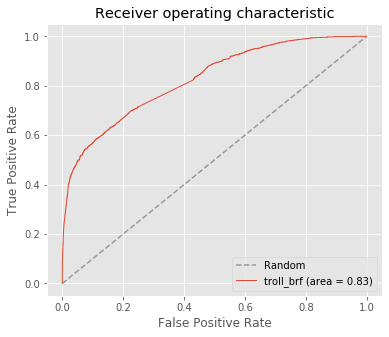

In [420]:
# 0.77 is the number to beat ... 0.83, yay!
# state of the art is arguably 0.85 ...
# http://web.stanford.edu/class/cs224n/reports/custom/15739845.pdf
# and that effort used transfer learning and Bert instead of tfidf
fig, ax = plt.subplots(1, figsize=(6, 5))
plot_roc_nofit(ax, Xcsdt_test, y_test, brf, 'troll_brf')

### pickle this model

In [ ]:
filename = 'data/saved_models/troll_with_replies_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(brf, fp)

#### inspect the models

In [ ]:
n_top_features_tfidf = 10
comms_features = (
    ['controversiality', 'score', 'norm_depth'] 
        + 
    ['num_replies', 'num_pred_child_of_troll']
)
Xcsdt_features = (tfidf_vectorizer.get_feature_names() + comms_features)

In [ ]:
# permutation importance keeps crashing my aws instance with 128 GB of RAM...can't use all the test data
len(Xcsdt_test)

In [ ]:
subsample_test_index = np.random.choice(range(len(Xcsdt_test)), size=10000, replace=False)
subsample_test_index

In [ ]:
Xcsdt_test[subsample_test_index].shape

In [ ]:
# what about permutation importance 
# running this on a 32-core, 128 GB machine with 10000 test samples takes about an hour...
# that's a lot of features to permute! A total of 5 million cells shuffled
n_top_features = n_top_features_tfidf + len(comms_features)

In [ ]:
result = permutation_importance(brf, Xcsdt_test[subsample_test_index], 
                                y_test.iloc[subsample_test_index], n_repeats=10,
                                random_state=42, n_jobs=-3)

In [ ]:
sorted_idx = result.importances_mean.argsort()[-n_top_features:]

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(Xcsdt_features)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
result.importances.shape

In [ ]:
# save this result...
filename = 'data/saved_models/perm_importance_troll_with_replies_brf.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(result, fp)

In [ ]:
filename = 'data/saved_models/perm_importance_troll_with_replies_brf.pkl'
with open(filename, 'rb') as fp:
    result = pickle.load(fp)
#result2.importances_mean.shape
result.importances.shape

In [407]:
filename = 'data/saved_models/troll_with_replies_brf.pkl'
with open(filename, 'rb') as fp:
    brf = pickle.load(fp)

In [ ]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5, ).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [ ]:
import pickle
filename = 'data/saved_models/no_controversiality_perm_importance_troll_with_replies_brf.pkl'
with open(filename, 'rb') as fp:
    result = pickle.load(fp)
#result2.importances_mean.shape
result.importances.shape

In [ ]:
comms_meta = ['score', 'norm_depth']
comms_features = (
        comms_meta 
#             + 
#         ['num_replies', 'num_pred_child_of_troll']
    )

In [ ]:
X_features = (tfidf_vectorizer.get_feature_names() + comms_features)
len(X_features)

In [ ]:
n_top_features_tfidf = 10
n_top_features = n_top_features_tfidf + len(comms_features)

In [ ]:
sorted_idx = result.importances_mean.argsort()[-n_top_features:]

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(X_features)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [28]:
pycurs = db['author'].find(
    {}, 
    {'_id': 0, 
     'id': 1, 
     '_fullname': 1, 
     'name': 1, 
     'verified': 1, 
     'created_utc': 1, 
     'link_karma': 1, 
     'comment_karma': 1})
# db['author'].find_one({})
pycurs.next()

{'_fullname': 't2_100267',
 'name': 'enzymeisme',
 'created_utc': 1470011124.0,
 'link_karma': 3714,
 'comment_karma': 33,
 'verified': True,
 'id': '100267'}

In [96]:
# 29461 comments have no author fullname. If they are from trolls then those author names are preserved in 'author'
204547 + 29461

234008

In [147]:
query = {}
fields = { '_id': 0 }
authors_list = list(db['author'].find( query, fields ))

In [149]:
authors = pd.DataFrame(authors_list)

In [151]:
comms[['name_author', 'created_utc_author', 'link_karma_author', 'comment_karma_author']] = comms.merge(
    authors[['_fullname', 'created_utc', 'link_karma', 'comment_karma']], 
    left_on='author_fullname', 
    right_on='_fullname', 
    suffixes=('_comms', '_author'),
    how='left', copy=False)[['name', 'created_utc_author', 'link_karma', 'comment_karma']]

In [153]:
comms['norm_author_created_utc'] = np.where(~comms['author_created_utc'].isna(), 
                                            comms['author_created_utc'], 
                                            comms['created_utc_author'])
# comms[~comms['created_utc_author'].isna()].head(1000)

In [155]:
comms['user_age'] = comms['created_utc'] - comms['norm_author_created_utc']

In [156]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234008 entries, 0 to 234007
Data columns (total 82 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57875 non-null   object 
 3   author_flair_text                59107 non-null   object 
 4   author_fullname                  204547 non-null  object 
 5   body                             234008 non-null  object 
 6   controversiality                 233374 non-null  float64
 7   created_utc                      234008 non-null  float64
 8   distinguished                    385 non-null     object 
 9   gilded                           233370 non-null  float64
 10  id                               234008 non-null  object 
 11  link_id                          234008 non-null  object 
 12  ne

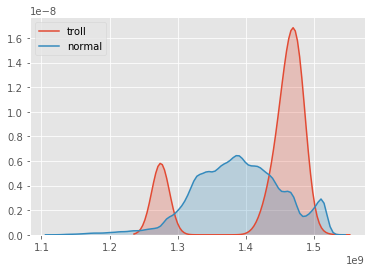

In [166]:
ax = sns.kdeplot(comms[comms['troll?'] == 1]['norm_author_created_utc'], label='troll', shade=True)
ax = sns.kdeplot(comms[comms['troll?'] == 0]['norm_author_created_utc'], label='normal', shade=True)
# ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
#                  cmap="Blues", shade=True, shade_lowest=False)

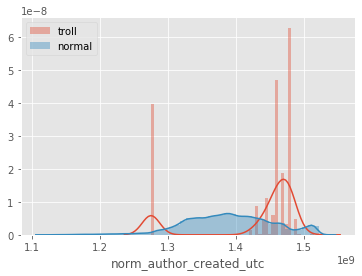

In [172]:
ax = sns.distplot(comms[comms['troll?'] == 1]['norm_author_created_utc'], label='troll')
ax = sns.distplot(comms[comms['troll?'] == 0]['norm_author_created_utc'], label='normal')
ax.legend()

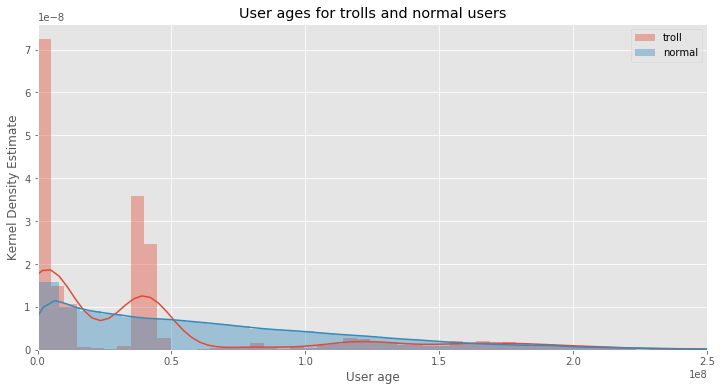

In [202]:
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.distplot(comms[comms['troll?'] == 1]['user_age'], label='troll', ax=ax)
sns.distplot(comms[comms['troll?'] == 0]['user_age'], label='normal', ax=ax)
ax.set_xlim((0, 250000000))
ax.set_xlabel('User age')
ax.set_ylabel('Kernel Density Estimate')
ax.set_title('User ages for trolls and normal users')
ax.legend()

In [211]:
[time.(ua) for ua in comms[~comms['user_age'].isna()]['user_age']]

TypeError: time() takes no arguments (1 given)

In [224]:
user_ages = comms[~comms['user_age'].isna()][['troll?', 'created_utc', 'norm_author_created_utc']]

In [225]:
timediff = []
for row in user_ages.values:
    timediff.append([row[0], dt.fromtimestamp(row[1]) - dt.fromtimestamp(row[2])])
# comms['user_age'] = np.where(comms['norm_author_created_utc'].isna(), )
timediff
# diff = dt.fromtimestamp(comms['created_utc']) - dt.fromtimestamp(comms['norm_author_created_utc'])

[[1.0, datetime.timedelta(days=163, seconds=76066)],
 [1.0, datetime.timedelta(days=163, seconds=74734)],
 [1.0, datetime.timedelta(days=163, seconds=74119)],
 [1.0, datetime.timedelta(days=163, seconds=73392)],
 [1.0, datetime.timedelta(days=147, seconds=86397)],
 [1.0, datetime.timedelta(days=136, seconds=1658)],
 [1.0, datetime.timedelta(days=135, seconds=79671)],
 [1.0, datetime.timedelta(days=135, seconds=78974)],
 [1.0, datetime.timedelta(days=135, seconds=76874)],
 [1.0, datetime.timedelta(days=135, seconds=75721)],
 [1.0, datetime.timedelta(days=135, seconds=75070)],
 [1.0, datetime.timedelta(days=135, seconds=74432)],
 [1.0, datetime.timedelta(days=135, seconds=70505)],
 [1.0, datetime.timedelta(days=135, seconds=69622)],
 [1.0, datetime.timedelta(days=135, seconds=69024)],
 [1.0, datetime.timedelta(days=135, seconds=66006)],
 [1.0, datetime.timedelta(days=135, seconds=64567)],
 [1.0, datetime.timedelta(days=135, seconds=53001)],
 [1.0, datetime.timedelta(days=135, seconds=521